# Telecom Churn Analysis

This notebook presents an analysis to analyse a data set containing customer information to identify customers which are likely to churn. It includes:
- Data cleaning
- Exploratory Data Analysis (EDA)
- Modelling
- Appendix (with some additional plotting)


In [1]:
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

sns.distributions._has_statsmodels=False

## Step 1 - Data cleaning

In [2]:
#read data
data=pd.read_csv('churn.csv')

In [3]:
#check data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#get some information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
#check distribution numerical values
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


#### The Total Charges data seems to have been imported as string, so we need to convert the data to numeric.

In [6]:
#Convert TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

In [7]:
#check if the transformation created any nulls
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

#### Given there are only 11 data points with missing data, for 7043 values, we can simply drop the rows with missing data instead of trying to fill the missing data with median or mean values.

In [8]:
#drop NaNs
data.dropna(inplace=True)

In [9]:
#Check uniqueness
data.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

## 2 - Exploratory Data Analysis

#### Create target y (Churn) and model features X, and explore the data to discover features that may be important.

In [10]:
#remove the customer IDS as they are unique values not related to churn.
X = data.drop(['Churn','customerID'], axis = 1).copy()
y = data['Churn'].copy()

In [11]:
#get categorical columns
categorical_columns=list(X.select_dtypes(['object']).columns)
#add SeniorCitizen as it is effectively categorical
categorical_columns.append('SeniorCitizen')
numerical_columns=[x for x in X.columns if x not in categorical_columns]

In [12]:
# transforn target to numeric, with Churn=Yes being 1, and Churn=No being 0.
y_ord = ce.OrdinalEncoder(cols = ['Churn'],
                           mapping=[{'col': 'Churn', 'mapping': {'Yes': 1, 'No': 0}}])
y_trans = y_ord.fit_transform(y)

### Overall, the total churn is quite high, with an overall churning rate of 26.5%.

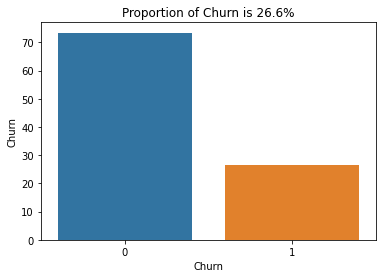

In [13]:
ax = sns.barplot(x="Churn", y="Churn", data=y_trans, estimator=lambda x: len(x) / len(y_trans) * 100).set_title(f'Proportion of Churn is {100*sum(y_trans["Churn"])/len(y_trans):.1f}%')

### Influence of variables on Churn

#### First categorical variables

In [14]:
#first get proportions of different variables that churn ans store in a dictionary
data_transformed = pd.concat([X.loc[:,categorical_columns],y_trans],axis=1)
proportions={}
for col in categorical_columns:
    temp={}
    for var in list(set(data_transformed[col])):
        temp[var]=sum(data_transformed[data_transformed[col]==var]['Churn'])/len(data_transformed[data_transformed[col]==var]['Churn'])
    proportions[col]=temp

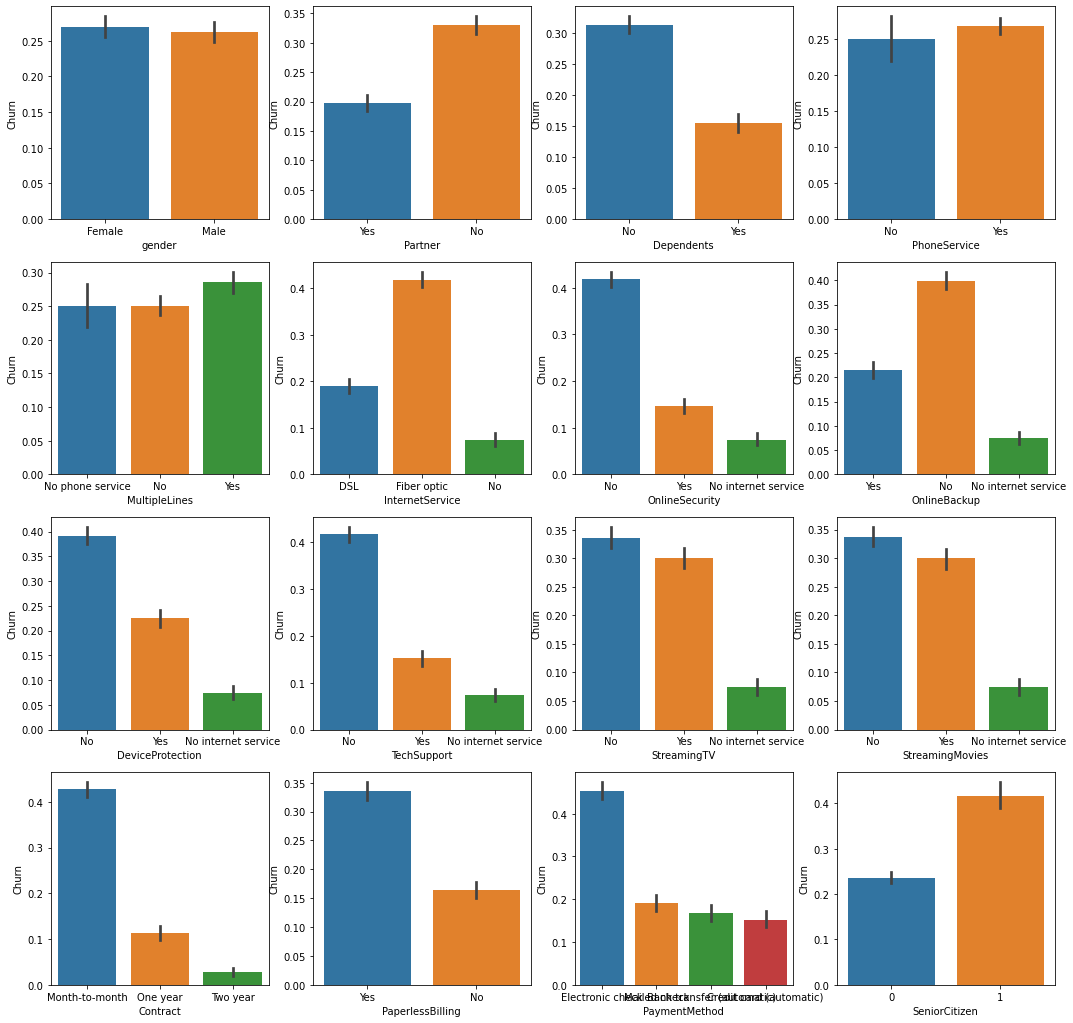

In [15]:
#plot proportion of churn 
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
for col, ax in zip(data_transformed.columns, axes.flatten()):
    if col != 'Churn':
        g = sns.barplot(x=col, y="Churn", data=data_transformed, ax=ax) 

#### Now for numerical features

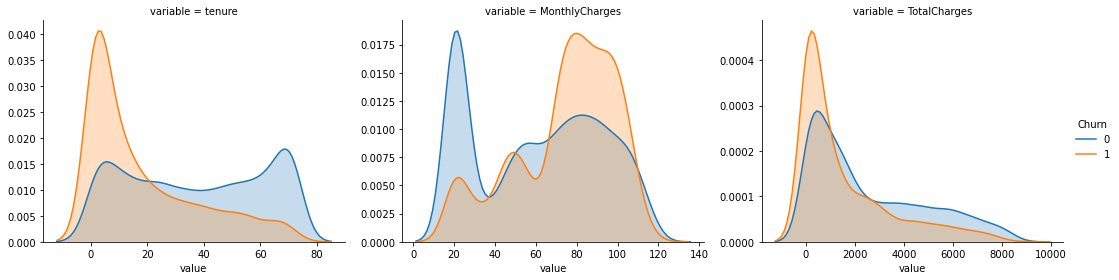

In [16]:
data_transformed = pd.concat([X.loc[:,numerical_columns],y_trans],axis=1)
data_transformed_melt = pd.melt(data_transformed, data_transformed.columns[-1], data_transformed.columns[:-1])

g = sns.FacetGrid(data_transformed_melt, col="variable", hue="Churn", col_wrap=3, sharex=False, sharey=False,height=4,aspect=1.25)
g.map(sns.kdeplot, "value", shade=True)
g.add_legend();

### Observations from EDA
- Customers on month to month basis contracts are 3.7x more likely to churn than customers on 1 Year contracts, and 15x times more likely than customers on a 2 year contract
- Customers on lower tenure (recent signing) are more likely to churn, and so are customers with larger monthly charges
- Customers with Paperless billing are more likely to churn
- Customers who pay by 'Electronic check' are 2-3x as likely to churn compared to other methods
- Customer on Optic Fiber are 2 x times more likely to churn than customers with DSL, and 5x more than customers without internet
- There is little difference in churn for customers with or without streaming services (TV or movies)
- Customers without Online Security, Device Protection and Tech Support are more likely to churn that customers that do have those features
- The initial analysis suggests there may be a correlation between a customer partner and dependednts condition on churn
- There are no effects of gender, multiple lines and the presence/absence of a phone service on Churn, although senior citizen's seem to churn more often than non-senior customers

## 3 - Modelling

In this step, the objective is to try and devlop a model to estimate our ability to predict customers that are likely to churn, and identify which variables have more influence and have actual predictive power for churn.

### Data transformation
The first step is to convert the categorical features to numerical.

In [17]:
#Identify required categorical values for tranformation in each columns:
for column in categorical_columns:
    print(f'{column}, {set(X[column])}')

gender, {'Male', 'Female'}
Partner, {'Yes', 'No'}
Dependents, {'Yes', 'No'}
PhoneService, {'Yes', 'No'}
MultipleLines, {'No phone service', 'Yes', 'No'}
InternetService, {'DSL', 'Fiber optic', 'No'}
OnlineSecurity, {'Yes', 'No', 'No internet service'}
OnlineBackup, {'Yes', 'No', 'No internet service'}
DeviceProtection, {'Yes', 'No', 'No internet service'}
TechSupport, {'Yes', 'No', 'No internet service'}
StreamingTV, {'Yes', 'No', 'No internet service'}
StreamingMovies, {'Yes', 'No', 'No internet service'}
Contract, {'Month-to-month', 'One year', 'Two year'}
PaperlessBilling, {'Yes', 'No'}
PaymentMethod, {'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check'}
SeniorCitizen, {0, 1}


In [18]:
#Use a ordinal encoder with set mapping, just using 0/1
ce_ord = ce.OrdinalEncoder(mapping=[{'col': 'gender', 'mapping': {'Female': 1, 'Male': 0}},
                                    {'col': 'Partner', 'mapping': {'Yes': 1, 'No': 0}},
                                    {'col': 'Dependents', 'mapping': {'Yes': 1, 'No': 0}},
                                    {'col': 'PhoneService', 'mapping': {'Yes': 1, 'No': 0}},
                                    {'col': 'PaperlessBilling', 'mapping': {'Yes': 1, 'No': 0}},
                                    {'col': 'MultipleLines', 'mapping': {'Yes': 1, 'No': 0, 'No phone service':0}},
                                    {'col': 'OnlineSecurity', 'mapping': {'Yes': 1, 'No': 0, 'No internet service':0}},
                                    {'col': 'OnlineBackup', 'mapping': {'Yes': 1, 'No': 0, 'No internet service':0}},
                                    {'col': 'DeviceProtection', 'mapping': {'Yes': 1, 'No': 0, 'No internet service':0}},
                                    {'col': 'TechSupport', 'mapping': {'Yes': 1, 'No': 0, 'No internet service':0}},
                                    {'col': 'StreamingTV', 'mapping': {'Yes': 1, 'No': 0, 'No internet service':0}},
                                    {'col': 'StreamingMovies', 'mapping': {'Yes': 1, 'No': 0, 'No internet service':0}}])
X_trans = ce_ord.fit_transform(X, y)

In [19]:
#for the variables for which there is no "hierarchy", a target encoder is used - the values it maps each category 
#to are weighted averages of the target value.
target_encoder = ce.TargetEncoder(cols=['InternetService','Contract','PaymentMethod'])
X_trans = target_encoder.fit_transform(X_trans,y_trans)

### Check for correlations

In [20]:
df_corr = pd.concat([X_trans,y_trans],axis=1).corr()
df_corr.head()
#plt.figure(figsize=(12,10))
#sns.heatmap(df_corr, annot=True, cmap=plt.cm.bwr);

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,0.001819,0.001379,-0.010349,-0.005285,0.007515,0.008883,0.010531,0.016328,0.013093,0.000807,0.008507,0.007124,0.010105,0.002093,0.011902,-0.001799,0.013779,-0.000048,0.008545
SeniorCitizen,0.001819,1.000000,0.016957,-0.210550,0.015683,0.008392,0.142996,0.264836,-0.038576,0.066663,0.059514,-0.060577,0.105445,0.119842,0.142143,0.156258,0.161950,0.219874,0.102411,0.150541
Partner,0.001379,0.016957,1.000000,0.452269,0.381912,0.018397,0.142561,0.001082,0.143346,0.141849,0.153556,0.120206,0.124483,0.118108,-0.291314,-0.013957,-0.095126,0.097825,0.319072,-0.149982
Dependents,-0.010349,-0.210550,0.452269,1.000000,0.163386,-0.001078,-0.024307,-0.177475,0.080786,0.023639,0.013900,0.063053,-0.016499,-0.038375,-0.238612,-0.110131,-0.148876,-0.112343,0.064653,-0.163128
tenure,-0.005285,0.015683,0.381912,0.163386,1.000000,0.007877,0.332399,0.026892,0.328297,0.361138,0.361520,0.325288,0.280264,0.285402,-0.673232,0.004823,-0.240450,0.246862,0.825880,-0.354049


In [21]:
#Correlation with output variable
cor_target = abs(df_corr["Churn"])
#Selecting highly correlated features
relevant_features = list(cor_target[abs(cor_target)>0.2].index)
relevant_features.remove("Churn")
print(f'The features with the highest correlation to churn are {relevant_features}')

The features with the highest correlation to churn are ['tenure', 'InternetService', 'Contract', 'PaymentMethod']


### Set up test models

Set up test models with Logistic Regression, Random Forest Classifier and XGBoost. The models use KFold validation to estimate the effect of using a training set of 80% of size, with a validation set of 20%. KFold is used to make sure that the performance of the models is not due to a luck split.
As the dataset is imbalanced, a weight is applied to the models to account for the class imbalance.

In [22]:
#set up scoring measures
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'roc_auc_score' : make_scorer(roc_auc_score)}

kfold = StratifiedKFold(n_splits=5)

In [23]:
#set up and run XGBoost
estimate = len(y_trans[y_trans.Churn==0]) / len(y_trans[y_trans.Churn==1])
xgb_model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.005,scale_pos_weight=estimate,max_depth=5)
xgb_results = cross_validate(xgb_model, X_trans, y_trans.values.ravel(), cv=kfold,scoring=scoring)
xgb_results2 = cross_val_predict(xgb_model, X_trans, y_trans.values.ravel(), cv=kfold)
for key in scoring.keys():
    print(f"{key}: {xgb_results[f'test_{key}'].mean():.3f}, std: {xgb_results[f'test_{key}'].std():.3f}")

accuracy: 0.751, std: 0.017
precision: 0.521, std: 0.023
recall: 0.803, std: 0.019
roc_auc_score: 0.767, std: 0.014


In [24]:
#set up and run a random forest classifier
rfc_model = RandomForestClassifier(class_weight="balanced",n_estimators=500, max_depth = 5)
rfc_results = cross_validate(rfc_model, X_trans, y_trans.values.ravel(), cv=kfold,scoring=scoring)
for key in scoring.keys():
    print(f"{key}: {rfc_results[f'test_{key}'].mean():.3f}, std: {rfc_results[f'test_{key}'].std():.3f}")

accuracy: 0.753, std: 0.009
precision: 0.523, std: 0.011
recall: 0.803, std: 0.014
roc_auc_score: 0.769, std: 0.009


In [25]:
#set up and run logistic regression
lgr_model = LogisticRegression(max_iter=500,class_weight="balanced")
lgr_results = cross_validate(lgr_model, X_trans, y_trans.values.ravel(), cv=kfold,scoring=scoring)
for key in scoring.keys():
    print(f"{key}: {lgr_results[f'test_{key}'].mean():.3f}, std: {lgr_results[f'test_{key}'].std():.3f}")

accuracy: 0.752, std: 0.009
precision: 0.523, std: 0.011
recall: 0.778, std: 0.025
roc_auc_score: 0.760, std: 0.011


#### As the results above show small standard deviations, the model performance is not due to a lucky split. Although the model has a relatively low precision around 0.52 (so it is correct 50% of the time when it predicts churn), it has a recall around 0.76-0.80, so it correctly predicts around 80% of customers who churn. But as shown above, for the XGBoost model the false positive rate is around 0.268, so about 27% of customer that are unlikely to churn are being classified as likely to churn 

In [26]:
confusion_matrix(y_trans.values.ravel(), xgb_results2)
tn, fp, fn, tp = confusion_matrix(y_trans.values.ravel(), xgb_results2).ravel()
print(f'The false positve rate is {fp/(fp+tn):.3f}')

The false positve rate is 0.268


#### Before using the model in production, options such as tuning hyperparameters, model ensambling or up/downsampling can be used to improve precision. 
#### All three models have similar performance, with XGBoost showing marginally better recall, so the XGBoost is trained on the entire dataset, as the CV validation already provided a measure of performance on new data. The model can then be used to assess the importance of different features for model prediction.

In [27]:
#set up model based on whole dataset
model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.005,scale_pos_weight=estimate,max_depth=5)
model.fit(X_trans, y_trans.values.ravel());
model_probabilities = model.predict_proba(X_trans)

In [28]:
#get feature importance using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trans)

In [29]:
#Compute approcximation for probabilities
explainerModel_prob = shap.TreeExplainer(model,data = shap.sample(X_trans, 100),model_output='probability')
shap_values_model_prob  = explainerModel_prob.shap_values(X_trans,);

100%|===================| 7018/7032 [01:34<00:00]        

### Important Features
In this section, important models features are identified,  and the library SHAP is used to explore how much different features contribute to the overall probability of a customer churning. In the figure below, items in red show their contribution to the overal probability of churn, which is around 0.75. It is clear both Month-to_Month and tenure are the biggest contributors to the model predicting churn for this customer.


In [30]:
#plot example of contributions for the result for one customer
shap.initjs()
shap.force_plot(explainerModel_prob.expected_value, shap_values_model_prob[0,:], X.iloc[0,:])

#### As can be seen in the figure below, the most important feature is the type of contarct, followed by the tenure, internet service type (or absence), followed by charges and the payment method. The rest of the variables have lower importance for predicting churn in the model.

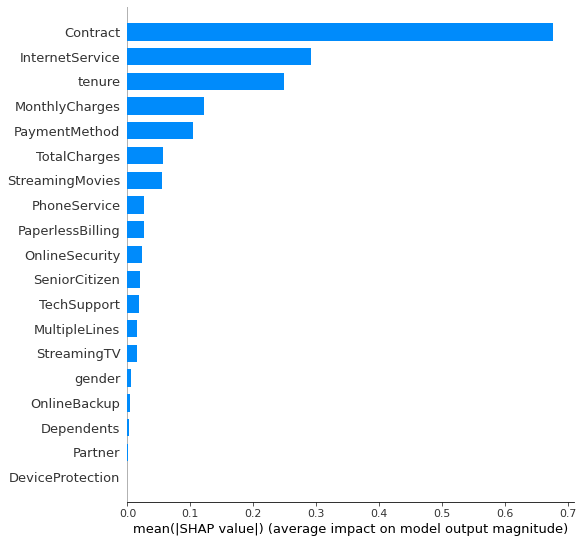

In [31]:
#plot feature importance
shap.summary_plot(shap_values, X_trans, plot_type="bar")

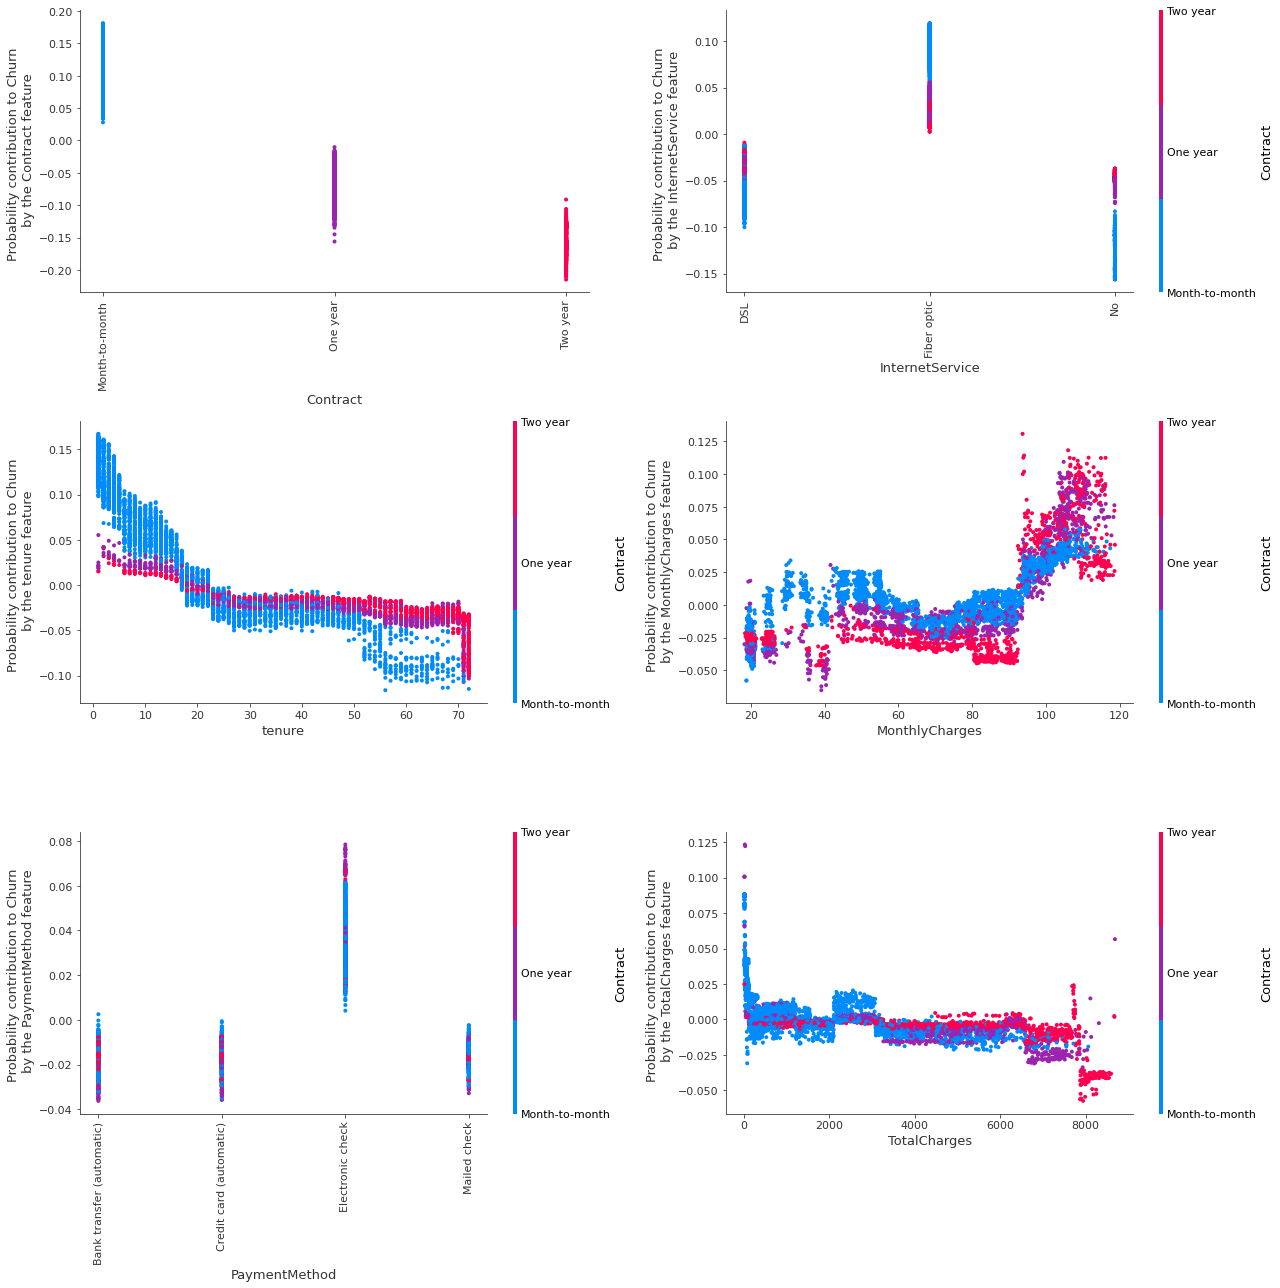

In [32]:
top6_features=['Contract','InternetService','tenure','MonthlyCharges','PaymentMethod','TotalCharges']
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

for col, ax in zip(top6_features, axes.flatten()):
    shap.dependence_plot(col, shap_values_model_prob, X,interaction_index="Contract",show=False, ax=ax)
    ax.set_ylabel(f"Probability contribution to Churn \n by the {col} feature")
plt.tight_layout()
plt.show()

## Conclusions

- Contract type is the most important feature, with month-to-month contract making the largest contribution to the risk of churning (top left, above)
- The second most import feature is the type of internet service, as customers with fiber optic internet show an increase risk of churning(top right, above). The risk is higher for customers on fiber optic and increase with price, but for DSL customer the risk is actually higher for customer on cheaper plans (depedence plots below, main feature=monthly charge)
- The duration of tenure is also an important feature, with newer customer on less than 20 months having the highest risk of churning (middle left, above). This is even true for customer on longer plans (but is a much smaller effect)
- For customer with a tenure of less than 6 months, the risk of churning is somewhat independent of monthly charges, but after 6 months customers on more expensive plans are more likely to churn than customer on cheaper plans (depedence plots below, main_feature=tenure)
- Customers that pay by electronic cheque have a much higher risk of churning, with positive probability contributions towards churning
- Customers with monthly charges above $80 have a higher probability of churning than customers on cheaper plans

## Appendix

#### Plot some figures of SHAP interactions to understand if there are other possible interactions we should consider

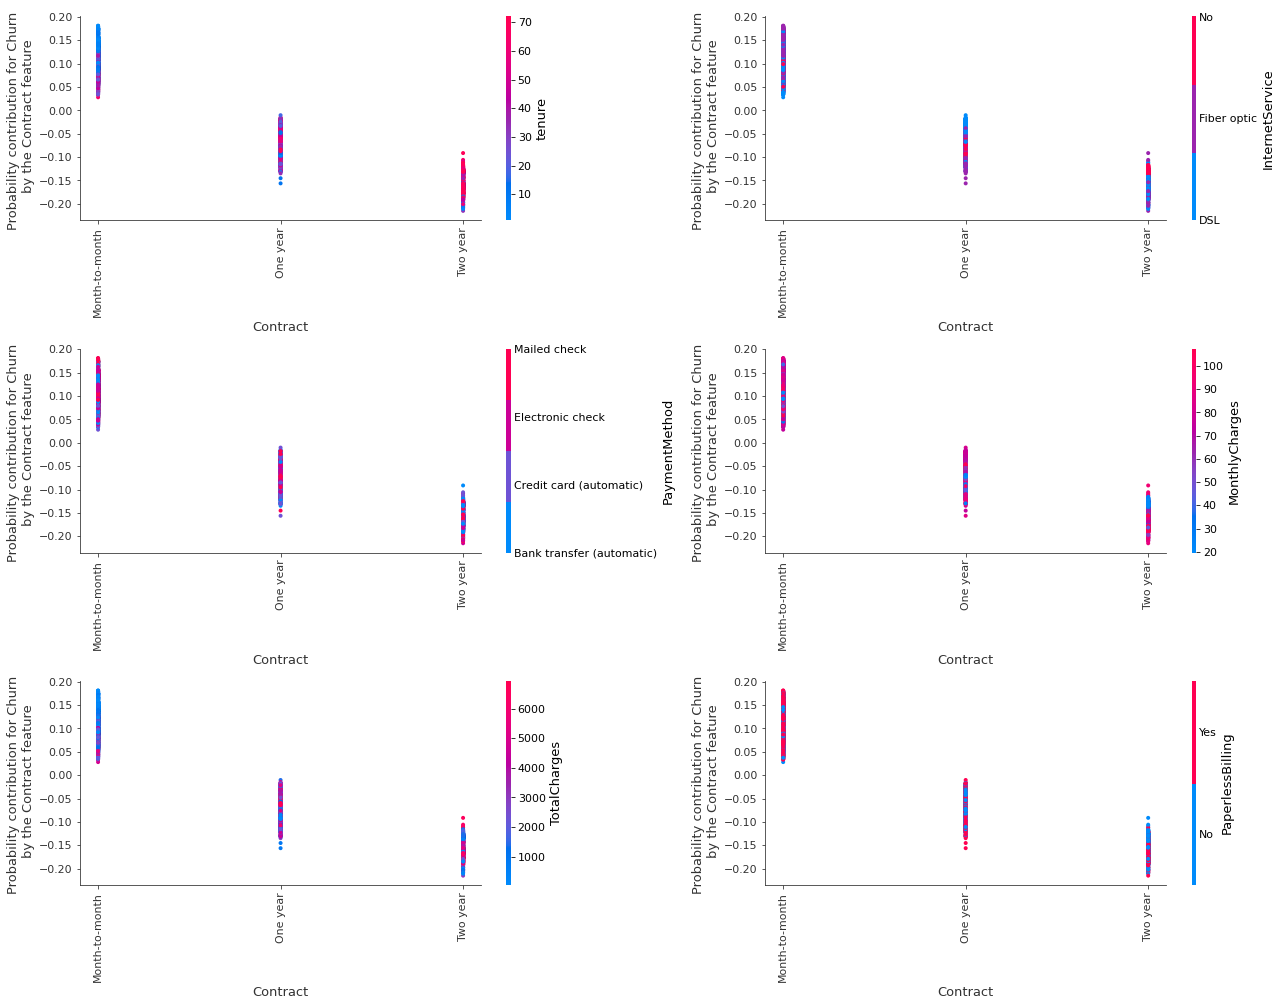

In [33]:
top7_features=['tenure','InternetService','Contract', 'PaymentMethod','MonthlyCharges', 'TotalCharges','PaperlessBilling']
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

main_feature='Contract'
features_plot= [x for x in top7_features if x != main_feature]
for col, ax in zip(features_plot, axes.flatten()):
    if col!=main_feature:
        shap.dependence_plot(main_feature, shap_values_model_prob, X,interaction_index=col,show=False,ax=ax)
        ax.set_ylabel(f"Probability contribution for Churn \n by the {main_feature} feature")
plt.tight_layout()
plt.show()


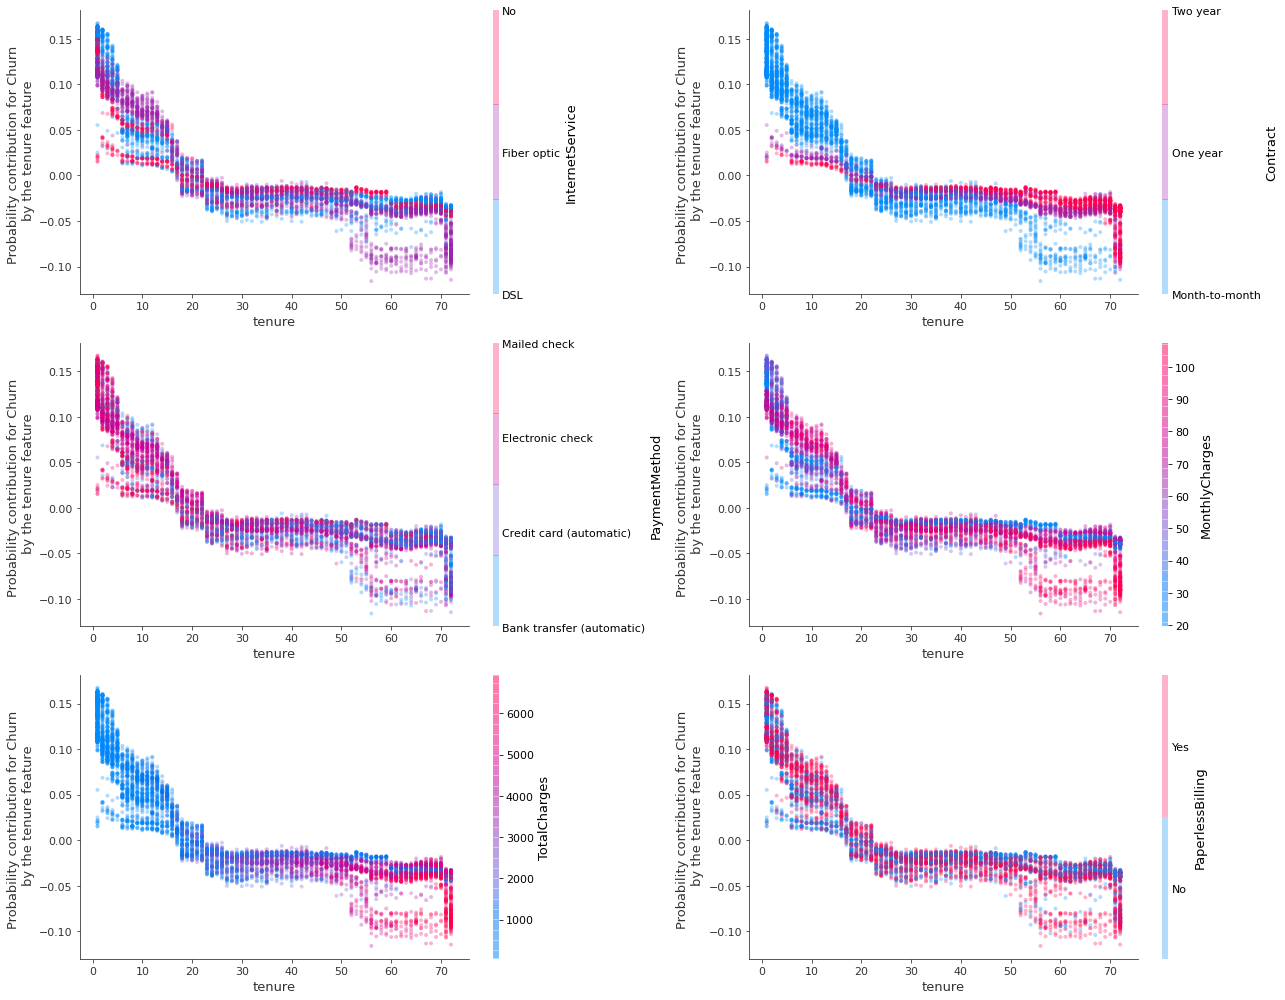

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

main_feature='tenure'
features_plot= [x for x in top7_features if x != main_feature]
for col, ax in zip(features_plot, axes.flatten()):
    if col!=main_feature:
        shap.dependence_plot(main_feature, shap_values_model_prob, X,interaction_index=col,show=False,ax=ax, alpha=0.3)
        ax.set_ylabel(f"Probability contribution for Churn \n by the {main_feature} feature")
plt.tight_layout()
plt.show()

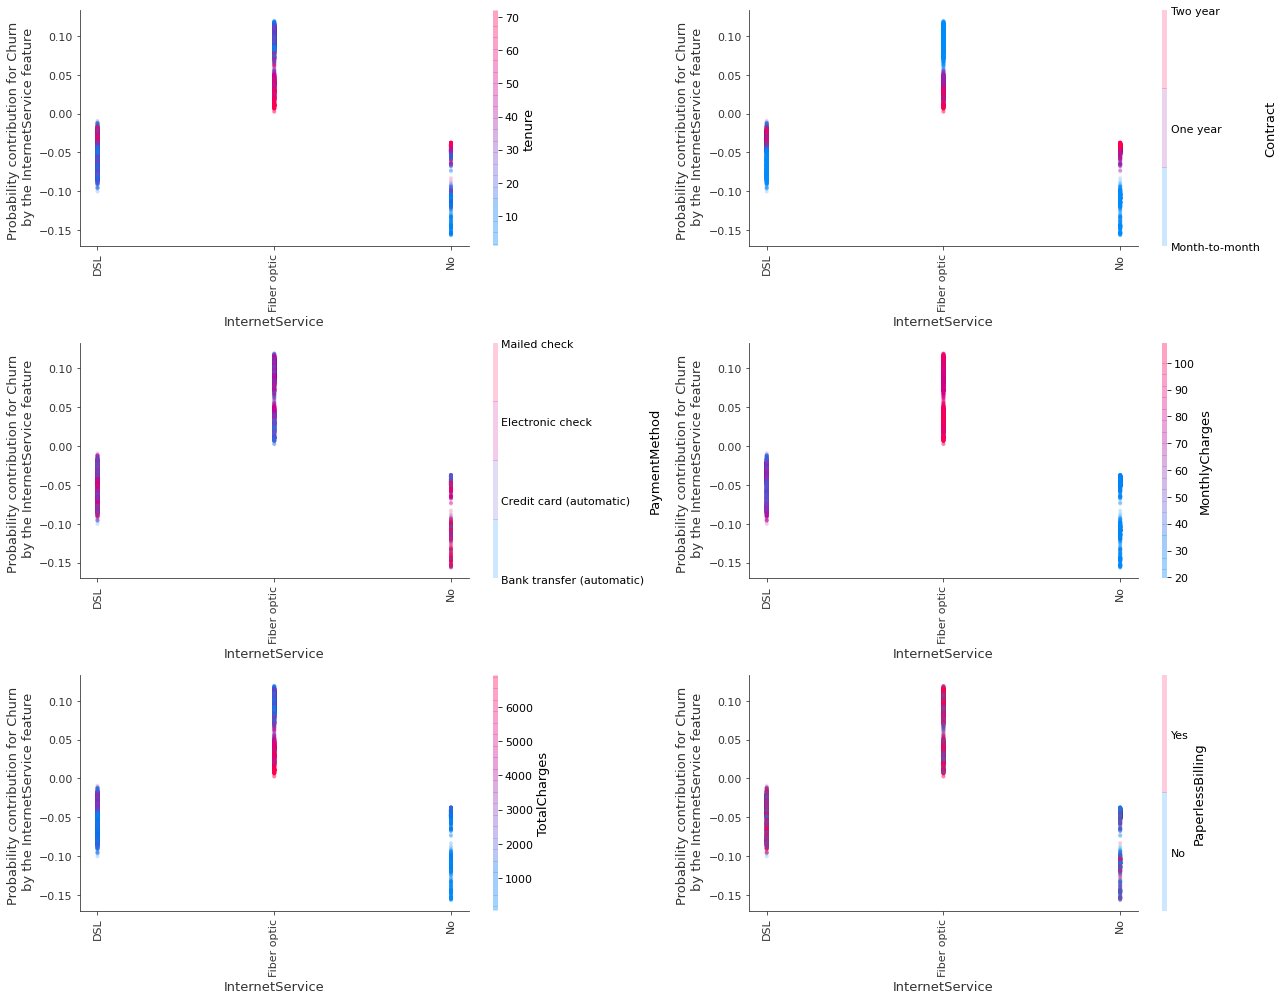

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

main_feature='InternetService'
features_plot= [x for x in top7_features if x != main_feature]
for col, ax in zip(features_plot, axes.flatten()):
    if col!=main_feature:
        shap.dependence_plot(main_feature, shap_values_model_prob, X,interaction_index=col,show=False,ax=ax,alpha=0.2)
        ax.set_ylabel(f"Probability contribution for Churn \n by the {main_feature} feature")
plt.tight_layout()
plt.show()

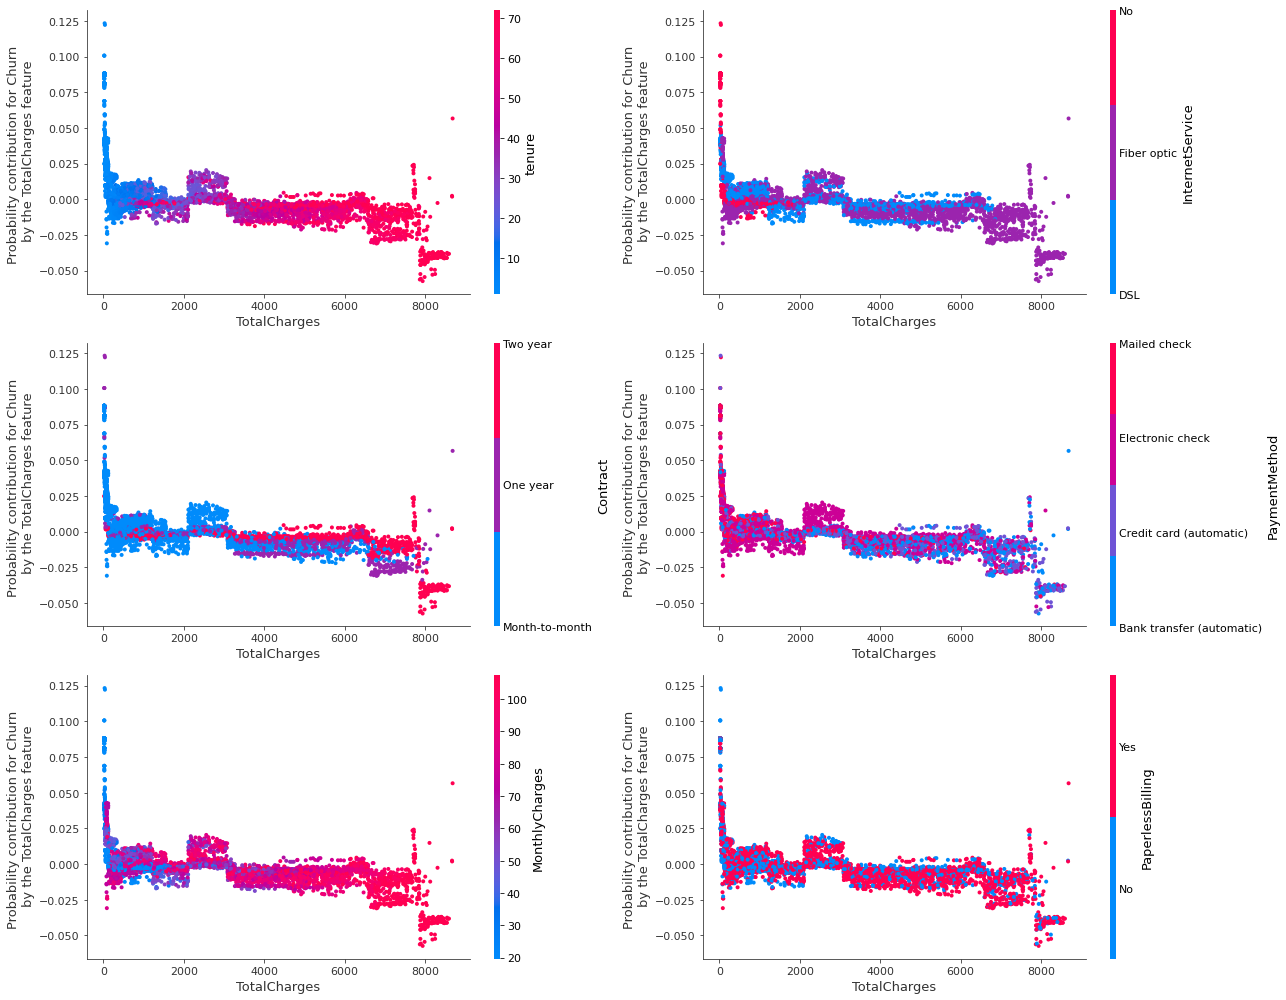

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

main_feature='TotalCharges'
features_plot= [x for x in top7_features if x != main_feature]
for col, ax in zip(features_plot, axes.flatten()):
    if col!=main_feature:
        shap.dependence_plot(main_feature, shap_values_model_prob, X,interaction_index=col,show=False,ax=ax)
        ax.set_ylabel(f"Probability contribution for Churn \n by the {main_feature} feature")
plt.tight_layout()
plt.show()

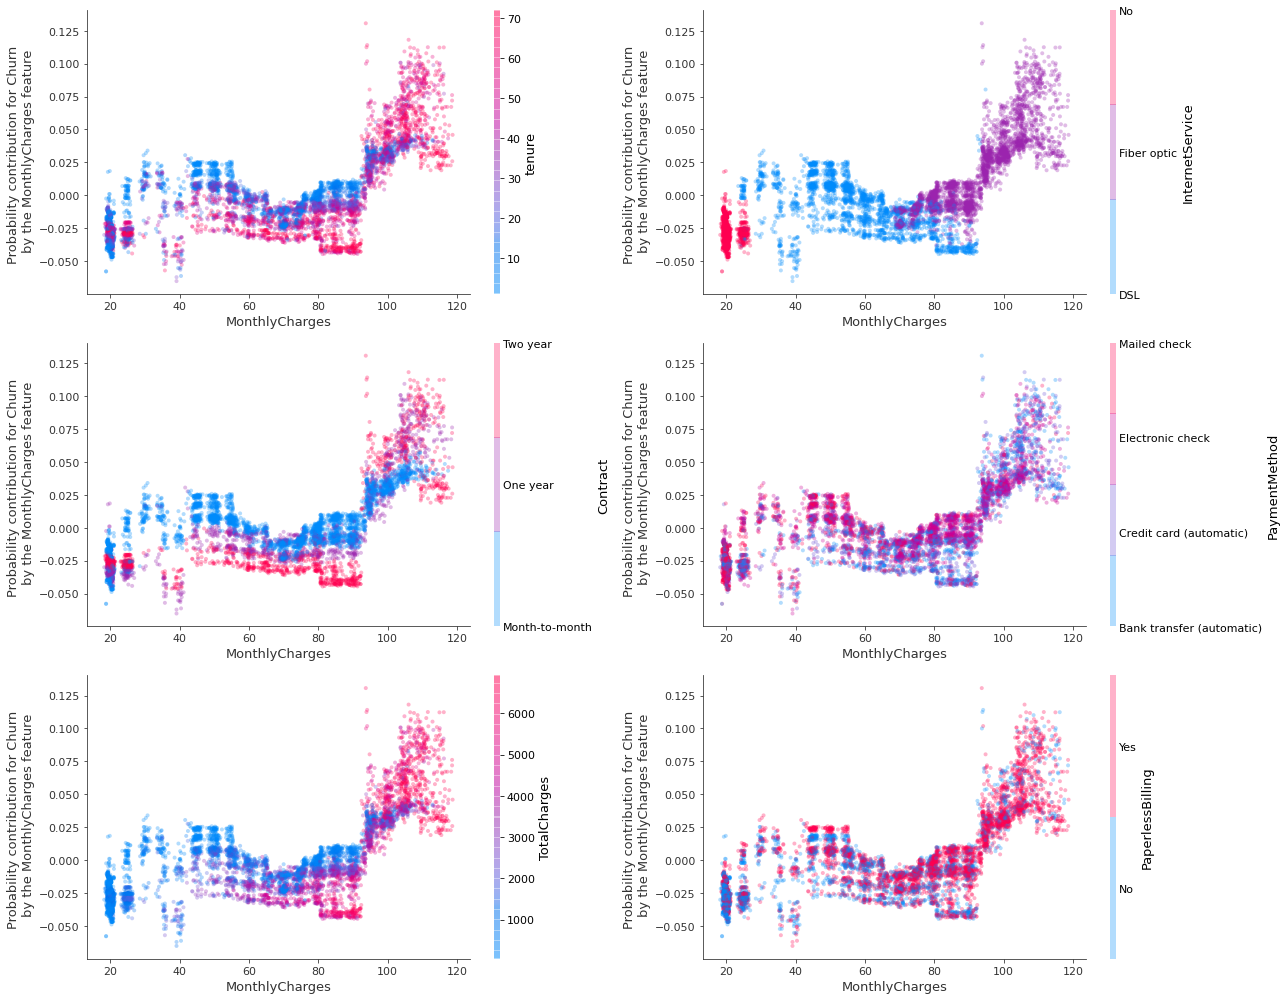

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

main_feature='MonthlyCharges'
features_plot= [x for x in top7_features if x != main_feature]
for col, ax in zip(features_plot, axes.flatten()):
    if col!=main_feature:
        shap.dependence_plot(main_feature, shap_values_model_prob, X,interaction_index=col,show=False,ax=ax, alpha=0.3)
        ax.set_ylabel(f"Probability contribution for Churn \n by the {main_feature} feature")
plt.tight_layout()
plt.show()

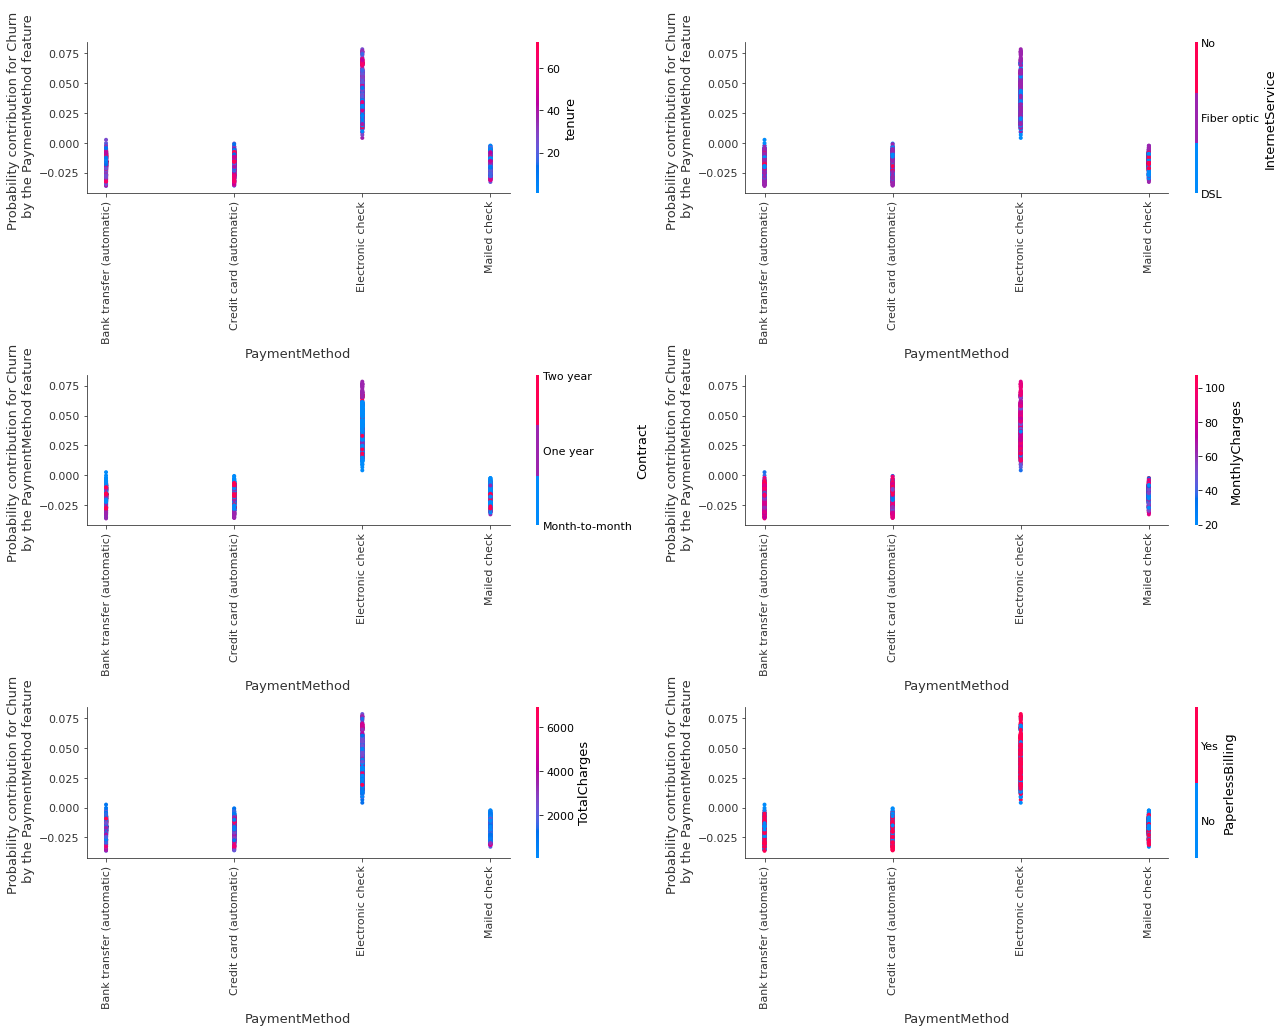

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

main_feature='PaymentMethod'
features_plot= [x for x in top7_features if x != main_feature]
for col, ax in zip(features_plot, axes.flatten()):
    if col!=main_feature:
        shap.dependence_plot(main_feature, shap_values_model_prob, X,interaction_index=col,show=False,ax=ax)
        ax.set_ylabel(f"Probability contribution for Churn \n by the {main_feature} feature")
plt.tight_layout()
plt.show()

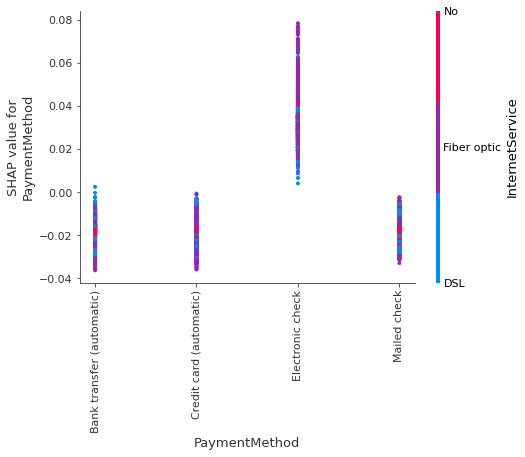

In [44]:
shap.dependence_plot('PaymentMethod', shap_values_model_prob, X,interaction_index="InternetService")